# Мобильное приложение для продажи продуктов питания.

**Описание проекта**\
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/B-теста. Для него пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
В случае общей аналитики и A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.\

**Описание данных**\
Каждая запись в логе — это действие пользователя, или событие.\
EventName — название события;\
DeviceIDHash — уникальный идентификатор пользователя;\
EventTimestamp — время события\
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# настройка окружения
pd.options.display.max_columns=None
pd.options.display.float_format='{:.2f}'.format
sns.set(style='whitegrid')
plt.style.use('seaborn-pastel')

In [3]:
# можно было обойтись seaborn, для эксперимента используем вариации Plotly
!pip install cufflinks plotly;

     |████████████████████████████████| 81kB 1.6MB/s eta 0:00:011
     |████████████████████████████████| 81kB 17.1MB/s eta 0:00:01


  Created wheel for cufflinks: filename=cufflinks-0.17.0-cp37-none-any.whl size=67745 sha256=38247342638e29c803995fcde3bcf22fd9ca9df2676c7d5c9e62216afc71b5a9
  Stored in directory: /home/jovyan/.cache/pip/wheels/44/d7/dc/e830ab00bc2dd3b2731295103baa070f8cbdda8891f71a7a8d
Successfully built cufflinks
ERROR: cufflinks 0.17.0 has requirement plotly>=4.1.1, but you'll have plotly 4.1.0 which is incompatible.


In [4]:
# импортирование plotly
#import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot

#Использование cufflinks в офлайн-режиме
import cufflinks
cufflinks.go_offline()

# Настройка глобальной темы cufflinks
cufflinks.set_config_file(world_readable=True, theme='pearl', offline=True);

<a id="content"></a>
## Содержание
[Шаг 1. Загрузка данных и общая оценка датасета](#1) \
[Шаг 2. Подготовка данных](#2) \
[Шаг 3. Изучение и проверка данных](#3) 
- [3.1. Оценка временного диапазона имеющихся данных](#31)
- [3.2. Очистка данных от неполных цепей событий.](#32)
- [3.3. Расчет характеристик датасета.](#33)

[Шаг 4. Изучение воронки событий](#4) \
[Шаг 5. Обработка результатов эксперимента](#5)\
- [5.1. Очистка данных от выбросов ](#51)
- [5.2. Подготовка данных ](#52)
- [5.3 Проверка результатов теста А/А](#53)
- [5.4. Статистическая проверка гипотез](#54)

**[Общий вывод](#summary)**

<a id="1"></a>
## Шаг 1. Загрузка данных и общая оценка датасета [▲](#content)


In [5]:
# загрузка исходного датасета
df_events = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [6]:
# визуальная оценка датасета
df_events.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<a id="2"></a>
## Шаг 2. Подготовка данных [▲](#content)

In [7]:
# Переименовываем столбцы для удобства
df_events.columns = ['event_name', 'user_id', 'event_ts', 'exp_id']

In [8]:
# преобразование даты-времени в столбце timestamp из unix формата в обычный
df_events['event_ts'] = pd.to_datetime(df_events['event_ts'], unit='s')

In [9]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_name    244126 non-null object
user_id       244126 non-null int64
event_ts      244126 non-null datetime64[ns]
exp_id        244126 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


In [10]:
# проверка на дубликаты
print('Число полных дубликатов в таблице:', df_events.duplicated().sum())

Число полных дубликатов в таблице: 413


In [11]:
# # визуальная проверка записей дубликатов
# df_events[df_events.duplicated(keep=False)==True].head(6)

In [12]:
# удаление дубликатов 
df_events.drop_duplicates(inplace=True)
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
event_name    243713 non-null object
user_id       243713 non-null int64
event_ts      243713 non-null datetime64[ns]
exp_id        243713 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


In [13]:
# создаем отдельные столбцы с датой 'date' и со временем 'time'
df_events['date'] = df_events['event_ts'].dt.date
df_events['time'] = df_events['event_ts'].dt.time
df_events.head()

,event_name,user_id,event_ts,exp_id,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


In [14]:
# оценка целостности данных в столбце 'event_name'
df_events['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Имеем 5 вариантов событий, опечаток в названиях нет. Все корректно.

In [15]:
df_events['exp_id'].value_counts()

248    85582
246    80181
247    77950
Name: exp_id, dtype: int64

Нумерация групп соответствует заявленной, "лишние" отсутствуют. Все в порядке.

In [16]:
# проверка корректности временных меток (оценка разброса мин-макс)
df_events['event_ts'].describe()

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: event_ts, dtype: object

Диапазон дат с 25 июля по 07 августа 2019 года. "Выбросы" возможных ошибок отсутствуют.

In [17]:
# добавляем столбец с ID операции (используем текущий индекс датасета)
df_events['operation_id'] = df_events.index

**Вывод:** Выполнено преобразование формата даты-времени, выполнена проверка заполнения полей 'event_name', 'exp_id'. Удалены дубликаты. Добавлены столбцы с датой и временем события. Диапазон дат у данных с 25 июля по 07 августа 2019 года

<a id="3"></a>
## Шаг 3. Изучение и проверка данных [▲](#content)

После удаления дубликатов в Шаге-2 в логе осталось **243713 записей.** 

<a id="31"></a>
### 3.1. Оценка временного диапазона имеющихся данных  [**↑**](#3)

In [18]:
# строим гистограмму зарегестрированных событий по датам
# (эксперемент с Plotly)
df_events.groupby('date')['event_name'].count().iplot(kind='bar', color='navy', title='Число событий по датам');

На графике видно, что основной массив событий происходил начиная с **01 августа по 07 августа 2019 года.** Возможно влияют особенности алгоритма регистрации данных эксперимента. Тем не менее, если соблюдено разделение на группы, данные могут быть вполне корректны. Проверим число возможных потреь при "обрезке":

In [19]:
# число записей до 01 августа 2019 
print('Общее число записей:', df_events.shape[0])
print('Число записей до 01 августа 2019г.:', df_events[df_events['date'] > np.datetime64('2019-07-31')].shape[0])

Общее число записей: 243713
Число записей до 01 августа 2019г.: 240887


При обрезке будет потеряно около **1,2% данных (3 из 243 тыс. записей)**, это допустимо, но в этом нет необходимости. Данные оставляем.

<a id="32"></a>
### 3.2. Очистка данных от неполных цепей событий. [**↑**](#3)

Часть событий в логах вполне может быть продолжением цепочки событий начатых до начала ведения лога. Поскольку нам нужны только те полные цепи, выполним соответсвующую обработку. При этом останутся неполные цепочки заканчивающиеся после окончания эксперимента, поскольку мы не можем знать на каком событии пользователь закончил использовать приложение.

Для удобства обработки вводим кодировку событий 'event_id' отражающую предполагаемую **последовательность действий пользователя:**
- 1 - MainScreenAppear   - главная страница / запуск приложения
- 2 - OffersScreenAppear - страница с офертой товаров (может быть многократный просмотр в течение одной сессии)
- 3 - CartScreenAppear   - страница корзины
- 4 - PaymentScreenSuccessful - страница подтверждения платежа
- 5 - Tutorial - видимо обучение, может идти в любом порядке после главной страницы. Необязателен.

**Основная обработка:**

In [20]:
# функция для присвоения событию кода по его названию
def event_id(event_name):
    if   event_name == 'MainScreenAppear':
        return 1
    elif event_name == 'OffersScreenAppear':
        return 2
    elif event_name == 'CartScreenAppear':
        return 3
    elif event_name == 'PaymentScreenSuccessful':
        return 4
    else:
        return 5

In [21]:
# добавляем столбец с кодом события
df_events['event_id'] = df_events.apply(lambda x: event_id(x['event_name']), axis=1)

In [22]:
# показ заглавной страницы имеет теперь код - 1
# выявляем первые события по всем пользователям
df_first_events = df_events.groupby(['user_id', 'event_id'])['event_ts'].min().reset_index()
df_first_events.columns = ['user_id', 'event_id', 'first_ts']
# формируем список пользователей у которых за весь период не было показа заглавной страницы (события с кодом 2-5)
list_id_with_MainScreenAppear = df_first_events[df_first_events['event_id'] == 1]['user_id'].values
df_first_events = df_first_events[df_first_events['event_id'] == 1]
print('Число пользователей имевших показ главной страницы за весь период:', len(list_id_with_MainScreenAppear))

Число пользователей имевших показ главной страницы за весь период: 7439


In [23]:
# формируем новый датасет очищенный от от "хвостов" прошлых событий
# очистка от пользователей не имевших показа главной страницы за весь период (события с кодом 2-5)
df_events_new = df_events[df_events['user_id'].isin(list_id_with_MainScreenAppear)]

In [24]:
# добавляем столбец со временем первого события 'MainScreenAppear' / показ первой страницы
df_events_new = (df_events_new.merge(df_first_events[['user_id', 'first_ts']], on=['user_id'], how='left'))
# оставляем записи с меткой времени позже или равной времени первого события
df_events_new = df_events_new[df_events_new['event_ts'] >= df_events_new['first_ts']]

**Проверка итогов обработки:**

In [25]:
# повторная группировка для определения первого события для проверки
df_first_events_new = (df_events_new.groupby('user_id')['event_ts'].min().reset_index()
      .merge(df_events_new[['user_id', 'event_ts', 'event_name']], on=['user_id', 'event_ts'], how='left'))

In [26]:
# число записей оставшихся после очистки
print('Число записей после очистки:', df_events_new.shape[0])
print('Число уникальных пользователей:', df_first_events_new['user_id'].nunique())
print('Число первых событий:')
df_first_events_new['event_name'].value_counts()

Число записей после очистки: 236071
Число уникальных пользователей: 7439
Число первых событий:


MainScreenAppear           7439
CartScreenAppear             10
Tutorial                      3
OffersScreenAppear            1
PaymentScreenSuccessful       1
Name: event_name, dtype: int64

Число событий MainScreenAppear совпадает с числом пользователей, значит обработка выполнена корректно. Одновременно видим что есть набор и других событий, вероятно timestamp для них совпадает с MainScreenAppear. Проверяем.

In [27]:
# пользователи имеющие несколько "первых событий"
df_first_events_new['user_id'].value_counts().head(3)

250419112136655315     2
5767286434014984014    2
4678455642406594279    2
Name: user_id, dtype: int64

In [28]:
# вывод "первых событий" по одному из пользователей
df_first_events_new[df_first_events_new['user_id'].isin(['250419112136655315'])]

,user_id,event_ts,event_name
185,250419112136655315,2019-08-01 18:26:44,MainScreenAppear
186,250419112136655315,2019-08-01 18:26:44,OffersScreenAppear


Гипотеза подтвердилась, timestamp совпадает до секнд сразу для нескольких событий. Скорее всего - баг.

**Вывод:** очистка датасета от "хвостов" прошлых событий выполнена успешно.

<a id="33"></a>
### 3.3. Расчет характеристик датасета. [**↑**](#3)

In [29]:
# проверка количества данных по экспериментальным группам
df_events['exp_id'].value_counts()

248    85582
246    80181
247    77950
Name: exp_id, dtype: int64

Число записей во всех экспериментальных группах соизмеримо.

In [30]:
print('Число записей после очистки:', df_events_new.shape[0])
print('Число уникальных пользователей:', df_events_new['user_id'].nunique())
print('Среднее число событий на одного пользователя: {:.2f}'. 
      format(df_events_new.shape[0]/df_events['user_id'].nunique()))

Число записей после очистки: 236071
Число уникальных пользователей: 7439
Среднее число событий на одного пользователя: 31.26


**Вывод:**\
**Основное сбор данных (по количеству) произошел в период с 01 по 08 августа 2019г.** \
После обработки имеем:
- общее число записей в логе - 236071;
- распределение записей по экспериментальным группам равномерное: по 78-85 тыс.; 
- число уникальных пользователей в логе: 7439;
- среднее число событий на одного пользователя: 31.26

<a id="4"></a>
## Шаг 4. Изучение воронки событий [▲](#content)

**Разделение событий на последовательность выполнено в предыдущем разделе. [↑](#32)**

In [31]:
# подготовка таблицы данных для воронки продаж
df_sales_funnel = (df_events_new.groupby('event_name')['user_id'].count().reset_index()
     .merge(df_events_new.groupby('event_name')['user_id'].nunique().reset_index(),  
      on='event_name')).sort_values(by='user_id_x', ascending=False)
df_sales_funnel.columns = ['event_name', 'total_events', 'total_users']

In [32]:
# удаляем строку статистики по посещению страницы обучения 'Tutorial'
df_sales_funnel = df_sales_funnel[~df_sales_funnel['event_name'].isin(['Tutorial'])]
# добавляем столбец step с % конверсии
df_sales_funnel['step'] = df_sales_funnel['total_users'] / df_sales_funnel['total_users'].iloc[0] * 100

**Таблица. Общее число: событий / пользователей / конверсия**

In [33]:
df_sales_funnel

,event_name,total_events,total_users,step
1,MainScreenAppear,119101,7439,100.00
2,OffersScreenAppear,44522,4473,60.13
0,CartScreenAppear,40206,3618,48.64
3,PaymentScreenSuccessful,32105,3420,45.97


**Воронка событий для общего датасета**

In [34]:
# строим воронку событий по числу пользователей
fig = go.Figure(go.Funnel(
    y = ["Основная страница","Страница оферты", "Корзина", "Оплачено"],
    x = df_sales_funnel['total_users'].values), 
    layout=dict(title='Воронка событий (число пользователей, чел.)'))
fig.show()

**Воронка событий по экспериментальным группам**

In [35]:
# строим воронку продаж по эксп. группам
events_heatmap = df_events_new.pivot_table(values='user_id', 
                                           columns='exp_id', index='event_name', aggfunc='nunique')
events_heatmap.drop(index = 'Tutorial',  inplace=True)
events_heatmap.columns = events_heatmap.columns.values
events_heatmap.sort_values(by=246, ascending=False, inplace=True)
# число событий по группам разное. Для получения соизмеримого результата переводим данный в процентный формат
# добавляем конверсию по отношению к первому событию 'MainScreenAppear'
events_heatmap = events_heatmap / events_heatmap.iloc[0] * 100

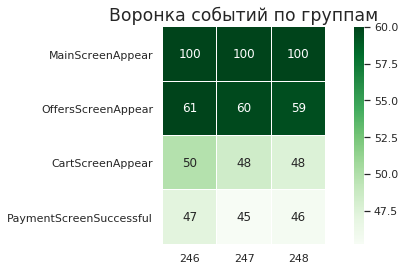

In [36]:
plt.figure(figsize=(10, 4))
sns.heatmap(events_heatmap, annot=True, fmt=".0f", linewidths=.1, square=True , vmax =60, cmap='Greens')
plt.title('Воронка событий по группам', fontdict={'fontsize': 'x-large'});
plt.ylabel('');
plt.rc('ytick', labelsize='large');

**Вывод:\
**46% пользователей доходит до покупки**, наибольшая потеря пользователей происходит на шаге от **MainScreenAppear            к OffersScreenAppear - остается 60%**, т.е. 40% пользователей даже не переходят до страницы с предложениями товара. Возможно есть проблемы интерфейса приложения. Запустить программу (а перед этим возможно дополнительно скачать, установить) и не посмотреть что продают - странно, бролее ожидаема потеря в пользователях была на этапе  перехода к корзине - CartScreenAppear.\
Воронка событий по группам эксперимента визуально не имеет существенных отличий, наиболее существенна разница между контрольными группами АА - до 2%.

<a id="5"></a>
## Шаг 5. Обработка результатов эксперимента [▲](#content)

**При проверке всех гипотез устанавливаем alpha = 5%**
***
Для проверки распределения на соответстве нормальному применяем критерий **Шапиро-Уилка**. 
***
Сравниваемые **выборки являются независимыми.**
***
Для проверки гипотез на выборках с нормальным распределением будем использовать **T-критерий Стьдента для независимых выборок**, и **критерий Манна-Уитни** если распределение выборок отлично от нормального.

<a id="51"></a>
### 5.1. Очистка данных от выбросов [**↑**](#5)

Поскольку у нас четыре категории основных событий, проводим очистку по всем группам генеральной выборки и после выполняем разбивку на группы AAB.

**Группировка по числу действий на каждого пользователя**

In [37]:
# создаем таблицу df_convers с числом действий по каждому пользователю          
# и для расчета параметров конверсии
# базовая группировка по пользователям-действиям
df_events_count = (df_events_new.groupby(['user_id', 'event_name'])['event_id', 'exp_id']
    .agg({'exp_id': 'min', 'event_id': 'count'}).reset_index())

# начинаем формировать таблицу df_convers
df_convers = df_events_count[df_events_count['event_name']=='MainScreenAppear']
df_convers.rename(columns={'event_id':'MainScreenAppear'}, inplace=True)
df_convers.drop(columns=['event_name'], inplace=True)
# действие однотипное, поэтому используем цикл для остальных значений
for event in ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    df_convers = df_convers.merge(df_events_count[df_events_count['event_name']==event]
                 [['user_id', 'event_id']], 
                 on ='user_id', how='left')
    df_convers.rename(columns={'event_id':event}, inplace=True)
df_convers.head(3)

,user_id,exp_id,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
0,6888746892508752,246,1,nan,nan,nan
1,6909561520679493,247,2,1.00,1.00,1.00
2,6922444491712477,246,19,12.00,8.00,8.00


In [38]:
# пустые данные при обработке получили значение 'nan', но в данном случае значение известно это - '0'
# т.е. установленное отсутствие события. Проводим замену 'nan' на '0'
df_convers.fillna(0, inplace=True)

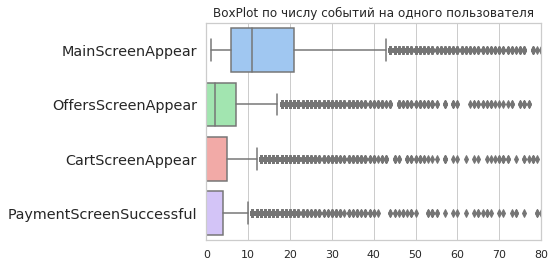

In [39]:
# Проверяем разброс числа событий на одного пользователя
sns.boxplot(data=df_convers[['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']],
           orient='h');
plt.title('BoxPlot по числу событий на одного пользователя')
plt.figsize=(5, 3)
plt.xlim(0,80);

**Имеют место значительные выбросы.** Проведем обработку данных. 

**Расчет перцентилей числа основных событий по пользователям**

In [40]:
# Расчет 95-го перцентиля по категориям событий для основной выборки
percentile=[]
for event in ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
      percentile.append([event, np.percentile(df_convers[event], 95)])
pd.DataFrame(percentile, columns=['event_name', 'percent_95'])

,event_name,percent_95
0,MainScreenAppear,45.00
1,OffersScreenAppear,24.00
2,CartScreenAppear,18.00
3,PaymentScreenSuccessful,14.00


**Отсекаем данные по соответствующим пользователям:**

In [41]:
df_convers_new = df_convers[(df_convers['MainScreenAppear'] < 45)&(df_convers['OffersScreenAppear'] < 24)
                        &(df_convers['CartScreenAppear'] < 18)&(df_convers['PaymentScreenSuccessful'] < 14)]

Поскольку удаление записей пользователей идет по всем категориям событий отдельно, размер датасета уменьшится больше чем на размер выбранного отчечения 5%. Выполняем проверку.

In [42]:
print('Число записей датасета после удаления экстермумов (% от исходного):',
      np.round(df_convers_new.shape[0] / df_convers.shape[0] * 100, 2))

Число записей датасета после удаления экстермумов (% от исходного): 87.14


**Вывод:** Удалены экстремумы на уровне перцентиля 95% по всем категориям событий. Итоговый размер датасета составил 87% от исходного, оставляем датасет в новой редакции.

In [43]:
df_convers = df_convers_new

<a id="52"></a>
### 5.2. Подготовка данных [**↑**](#5)

In [44]:
# расчет конверсии событий по этапам (по отношению к MainScreenAppear)
df_convers['offer'] = np.round(df_convers['OffersScreenAppear'] / df_convers['MainScreenAppear'], 2)
df_convers['cart'] = np.round(df_convers['CartScreenAppear'] / df_convers['MainScreenAppear'], 2)
df_convers['paid'] = np.round(df_convers['PaymentScreenSuccessful'] / df_convers['MainScreenAppear'], 2)

In [45]:
# проверка гипотезы, что число просмотров товаров может быть больше просмотров основной страницы
df_convers[df_convers['OffersScreenAppear'] > df_convers['MainScreenAppear']].head(3)

,user_id,exp_id,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,offer,cart,paid
25,33589551945846495,248,12,22.00,5.00,4.00,1.83,0.42,0.33
63,84107839139059565,246,17,20.00,7.00,6.00,1.18,0.41,0.35
66,89078601045475920,248,9,10.00,9.00,4.00,1.11,1.00,0.44


In [46]:
## проверка по отдельной записи
#df_events_new[df_events_new['user_id'].isin(['33589551945846495'])]

In [47]:
# разделение общей таблицы заказов по эксперементальным группам А1, А2 и В
sampleA1 = df_convers[df_convers['exp_id'].isin(['246'])]
sampleA2 = df_convers[df_convers['exp_id'].isin(['247'])]
sampleAA = df_convers[df_convers['exp_id'].isin(['246', '247'])]
sampleB = df_convers[df_convers['exp_id'].isin(['248'])]

<a id="53"></a>
### 5.3 Проверка результатов теста А/А [**↑**](#5)

**Число пользователей по эксперементальным группам:**

In [48]:
df_convers.groupby('exp_id')['user_id'].nunique()

exp_id
246    2161
247    2171
248    2150
Name: user_id, dtype: int64

Разбиение пользователей по группам  работает корректно.Размер групп составил: **от 2150 до 2171.**

**Проверка вида распределения конверсии по критерию Шапиро-Уилка.**\
Для выбора критерия сравнения, проверяем данные на соответствие нормальному распределению.

**Проверяем значения конверсии для рядов А/B и всей выборки. Гипотеза:**
- H0 - распределение выборки соответствует нормальному.
- H1 - распределение выборки отличается от нормального.
- alpha = 5%

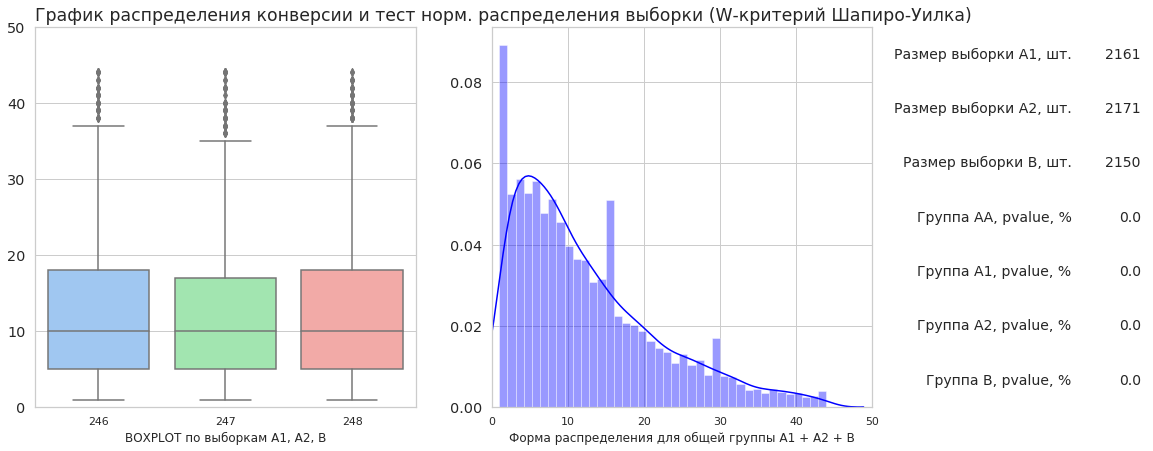

In [49]:
# событие для которого анализируем стат. показатели
event = 'MainScreenAppear'
# формируется таблица с данными теста Шапиро-Уилка
table_shapiro = ([['Размер выборки A1, шт.', sampleA1.shape[0]],
                  ['Размер выборки A2, шт.', sampleA2.shape[0]],
                  ['Размер выборки B, шт.', sampleB.shape[0]],
     ['Группа AA, pvalue, %', np.round(st.shapiro(sampleAA[event])[1]*100, 2)],
     ['Группа А1, pvalue, %', np.round(st.shapiro(sampleA1[event])[1]*100, 2)], 
     ['Группа A2, pvalue, %', np.round(st.shapiro(sampleA2[event])[1]*100, 2)],
     ['Группа B, pvalue, %', np.round(st.shapiro(sampleB[event])[1]*100, 2)]])
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
# графики распределения
sns.boxplot(data=df_convers, y=event, x='exp_id', ax=axes[0]);
sns.distplot(df_convers[event], bins=40, color='blue', ax=axes[1])
# вывод справочной таблицы
the_table = axes[1].table(cellText=table_shapiro, colWidths=[0.8, 0.2], bbox=(1.02, 0, 0.7, 1), edges='open');
the_table.auto_set_font_size(False)
the_table.set_fontsize(14);
# настройки отображения графиков
axes[0].set_title('График распределения конверсии и тест норм. распределения выборки (W-критерий Шапиро-Уилка)',
                   loc='left', fontdict={'fontsize':'x-large'});
axes[0].set_xlabel('BOXPLOT по выборкам A1, A2, B')
axes[0].set_ylabel('')
axes[0].set_ylim(0, 50);
axes[1].set_xlabel('Форма распределения для общей группы A1 + A2 + B');
axes[1].set_xlim(0, 50);


Для всех рядов значение pvalue меньше принятого значение alpha=5%. **Отвергаем H0 о соответствии распределения 
нормальному.**

Критерий Манна-Уитни не покажет тонких различий между выборками. Причина в том, что t-критерий работает на основе сравнения средних из фактических наблюдений, в то время как U-критерий Манна-Уитни использует сравнение рангов (номеров наблюдения в упорядоченной выборке), что позволяет ему быть устойчивым к выбросам. Но при этом критерий Манна-Уитни чувствителен к различию дисперсий и на больших выборках это станет заметно. Если объем выборки больше 20, то распределение выборки для U-критерия быстро сходится к нормальному распределению.\
Можно использовать t-test для оценки средних на большой выборке, так как нормальность обеспечивается ЦПТ (средние отдельных выборок распределения любого вида распеределены нормально). Поэтому t-test не подходит для небольших выборок из ненормального распределения, но подойдет для большой выборки из ненормального распределения.

**Вывод:** Распределение данных непараметрическое, это видно и визуально и согласно тесту Шапиро-Уилка. Однако, поскольку имеем **более 2 000 наблюдений** в каждой выборке, согласно ЦПТ, распределение средних любого распределения будет подчиняться нормальному закону и **можно использовать для проверки t-критерий Стьюдента для независимых выборок.**

<a id="54"></a>
### 5.4. Статистическая проверка гипотез [**↑**](#5)

 **Проверяем гипотезу о равенстве конверсии событий для рядов А1, А2, АА, B. Гипотеза:**
 - H0 - конверсия событий в рядах равна.
 - H1 - конверсия событий в рядах отличается.
 - alpha = 5%

In [50]:
# функция для получения имени переменной
def retrieve_name(x, Vars=vars()):
    for k in Vars:
        if type(x) == type(Vars[k]):
            if x is Vars[k]:
                return k
    return None

In [51]:
# функция проверки выборок на равенство среднего по Т-критерию Стьюдента
# по четырем группам событий
# вывод в формата DataFrame; A, B - Series с данными
def ttest_ind(A, B):
    table_ttest=[]
    for event in ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful',
                 'offer', 'cart', 'paid']: 
        table_ttest.append([event, np.round(st.ttest_ind(A[event], B[event])[1], 2)])
    return  pd.DataFrame(data=table_ttest, columns=['event_name', retrieve_name(A)+'-'+retrieve_name(B)])

In [52]:
ttest_table = (ttest_ind(sampleA1, sampleA2)
     .merge(ttest_ind(sampleA1, sampleAA), on = 'event_name')
     .merge(ttest_ind(sampleA2, sampleAA), on = 'event_name')
     .merge(ttest_ind(sampleA1, sampleB), on = 'event_name')
     .merge(ttest_ind(sampleA2, sampleB), on = 'event_name')
     .merge(ttest_ind(sampleAA, sampleB), on = 'event_name'))
ttest_table.style.background_gradient(cmap=sns.light_palette('limegreen', as_cmap=True))

,event_name,sampleA1-sampleA2,sampleA1-sampleAA,sampleA2-sampleAA,sampleA1-sampleB,sampleA2-sampleB,sampleAA-sampleB
0,MainScreenAppear,0.7,0.83,0.82,0.94,0.65,0.76
1,OffersScreenAppear,0.41,0.64,0.64,0.05,0.25,0.07
2,CartScreenAppear,0.38,0.61,0.61,0.88,0.47,0.74
3,PaymentScreenSuccessful,0.24,0.5,0.5,0.58,0.54,0.97
4,offer,0.64,0.79,0.79,0.24,0.49,0.29
5,cart,0.82,0.9,0.9,0.7,0.52,0.56
6,paid,0.69,0.82,0.82,0.57,0.32,0.37


In [53]:
print('Проведено статистических тестов всего:', ttest_table.shape[1] * (ttest_table.shape[1] - 1))

Проведено статистических тестов всего: 42


**Вывод:**\
Проведены t-тесты Стюдента попарно для имеющихся выборок для всех событий, включая показатели конверсии к первому событию  'MainScreenAppear': 'offer', 'cart', 'paid'.\
**Всего проведено - 42 теста.**\
**На принятом уровне значимости 5% статистически значимые отличия во всех сравнениях отсутствуют.**\
На "грани отвержения" нулевой гипотезы находится сравнение эксп. группы с новыми шрифтами В и контрольной А1 и обобщенной АА для события - 'OffersScreenAppear' - 'Показ окна с офертой', это 5% и 7%. При уровне значимости 10% можно было говорить об имеющемся отличии для этих рядов событий. Однако уровень значимости в той же паре АА-В для события PaymentScreenSuccessful находится на уровне 97%, выше чем между контрольными группами АА.

**PS** \
В задании говорится о повторении расчетов в случае принятия другого уровня значимости. Не понял для чего их повторять. Думается уровень значимости стоит принимать до теста, а не после, иначе похоже на подгонку результата.

<a id="summary"></a>
## Общий вывод [▲](#content)

**При изменении шрифтов в приложении статистически значимые отличия во всех экспериментальных группах отсутствуют на уровне значимости 5% .**\

**До покупки доходит 46% пользователей.**\

**Наибольшая потеря пользователей происходит на шаге от MainScreenAppear к OffersScreenAppear - остается 60%**,\
т.е. 40% пользователей даже не переходят до страницы с предложениями товара.\
Возможно есть проблемы интерфейса приложения на главной странице. 